In [1]:
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from collections import namedtuple, Counter
from random import shuffle
import pickle
import pandas as pd
import multiprocessing
import time
import numpy as np
import re
import random
import matplotlib.pyplot as plt


%matplotlib inline

numcores = multiprocessing.cpu_count()
numcores = 3

In [2]:
model = Doc2Vec.load('data/model-week4-clean')

In [3]:
aotable = pickle.load(open('data/AOmasterdata-nodup-week4-clean', 'rb'))

aotable.head(3)

,id,title,subtitle,city,country,location,url,physical_status,lat,lng,keywords,description,imgurl,subdesc,normsubdesc,tokens,weirdness,weirdpct
0,5561,Lake Hillier,An Australian lake whose pink hue defies scien...,,Australia,Australia,https://www.atlasobscura.com/places/lake-hillier,,-34.094179,123.203276,"wonders of salt,natural wonders,watery wonders","From a distance, Lake Hillier of Australia’s R...",https://assets.atlasobscura.com/media/W1siZiIs...,An Australian lake whose pink hue defies scien...,an australian lake whose pink hue defies scien...,"[an, australian, lake, whose, pink, hue, defie...",0.132377,26.78
1,4290,Gippsland Lakes Bioluminescence,Australian Lake set aglow by Noctiluca Scintil...,Raymond Island,Australia,"Raymond Island, Australia",https://www.atlasobscura.com/places/lake-gipps...,,-37.922431,147.791342,"watery wonders,bioluminescence","The conditions were rare, and they were perfec...",https://assets.atlasobscura.com/media/W1siZiIs...,Australian Lake set aglow by Noctiluca Scintil...,australian lake set aglow by noctiluca scintil...,"[australian, lake, set, aglow, by, noctiluca, ...",0.142318,4.00
2,596,The Haunted Bookshop,"Occult books, Tarot, Oddities.",Melbourne,Australia,"Melbourne, Australia",https://www.atlasobscura.com/places/haunted-bo...,,-37.815472,144.961689,"repositories of knowledge,occult,bookstores",The creepy Haunted Bookshop in Melbourne is lo...,https://assets.atlasobscura.com/media/W1siZiIs...,"Occult books, Tarot, Oddities.The creepy Haunt...","occult books , tarot , oddities the creepy h...","[occult, books, tarot, oddities, the, creepy, ...",0.122837,70.29


# Understanding the OddScore

In [4]:
aotable.sort_values('weirdpct', ascending = False).head(10)

,id,title,subtitle,city,country,location,url,physical_status,lat,lng,keywords,description,imgurl,subdesc,normsubdesc,tokens,weirdness,weirdpct
9450,476,Crypt of Civilization,The world's first time capsule lies behind a w...,Atlanta,United States,"Atlanta, Georgia",https://www.atlasobscura.com/places/crypt-civi...,,33.875119,-84.331913,"catacombs, crypts, & cemeteries,astounding tim...",The Crypt of Civilization at Oglethorpe Univer...,https://assets.atlasobscura.com/media/W1siZiIs...,The world's first time capsule lies behind a w...,the world first time capsule lies behind a wel...,"[the, world, first, time, capsule, lies, behin...",0.093466,99.99
4402,28355,Aero Beach,An aeronautical-themed resort forged around ru...,Entebbe,Uganda,"Entebbe, Uganda",https://www.atlasobscura.com/places/aero-beach,,0.038699,32.461252,"beaches,aircraft,airplane graveyard,airports,b...","Leaning into the soft lakeside soil, or sandwi...",https://assets.atlasobscura.com/media/W1siZiIs...,An aeronautical-themed resort forged around ru...,an aeronautical themed resort forged around ru...,"[an, aeronautical, themed, resort, forged, aro...",0.096392,99.99
10921,17584,Josephine Tussaud Wax Museum,This quirky Arkansas wax museum does not shy a...,Hot Springs,United States,"Hot Springs, Arkansas",https://www.atlasobscura.com/places/josephine-...,,34.516073,-93.053774,"wax museum,celebrity,national parks",The Josephine Tussaud Wax Museum may not have ...,https://assets.atlasobscura.com/media/W1siZiIs...,This quirky Arkansas wax museum does not shy a...,this quirky arkansas wax museum does not shy a...,"[this, quirky, arkansas, wax, museum, does, no...",0.097728,99.98
9586,7438,Moes Books,"A shape-shifting buy-sell-trade bookstore, bor...",Berkeley,United States,"Berkeley, California",https://www.atlasobscura.com/places/moe-s-books,,37.865506,-122.258644,"bookstores,commercial curiosities,repositories...",Located on the equally enigmatic Telegraph Ave...,https://assets.atlasobscura.com/media/W1siZiIs...,"A shape-shifting buy-sell-trade bookstore, bor...","a shape shifting buy sell trade bookstore , b...","[a, shape, shifting, buy, sell, trade, booksto...",0.097759,99.97
13446,4270,Enchanted Forest Theme Park,Remnants of a storybook amusement park hidden ...,Ellicott City,United States,"Ellicott City, Maryland",https://www.atlasobscura.com/places/enchanted-...,CLOSED,39.287087,-76.803118,"abandoned,abandoned amusement parks,roadside a...","Opening in 1955 (a month after Disneyland), Th...",https://assets.atlasobscura.com/media/W1siZiIs...,Remnants of a storybook amusement park hidden ...,remnants of a storybook amusement park hidden ...,"[remnants, of, a, storybook, amusement, park, ...",0.098559,99.96
5511,1835,Brioni,Island wonderland for communist autocrats.,Pula,Croatia,"Pula, Croatia",https://www.atlasobscura.com/places/brioni,,44.916667,13.766667,"anomalous islands,unique collections",There are two Adriatic islands intricately lin...,https://assets.atlasobscura.com/media/W1siZiIs...,Island wonderland for communist autocrats.Ther...,island wonderland for communist autocrats ther...,"[island, wonderland, for, communist, autocrats...",0.098688,99.96
12203,1314,Mukluk Land,This junkyard made over as a theme park is the...,Tok,United States,"Tok, Alaska",https://www.atlasobscura.com/places/mukluk-land,,63.351638,-143.209328,purveyors of curiosities,"The tiny town of Tok, located at the intersect...",https://assets.atlasobscura.com/media/W1siZiIs...,This junkyard made over as a theme park is the...,this junkyard made over as a theme park is the...,"[this, junkyard, made, over, as, a, theme, par...",0.100412,99.95
10202,16341,Nepenthe,Offering commanding views of the California co...,Big Sur,United States,"Big Sur, California",https://www.atlasobscura.com/places/nepenthe,,36.221803,-121.759233,"panoramas,mountains,restaurants",Perched high atop a peak in the Santa Lucia Mo...,https://assets.atlasobscura.com/media/W1siZiIs...,Offering commanding views of the 

# Step 1: t-SNE

In [99]:
docsinfo = pd.DataFrame.from_dict(model.docvecs.doctags, orient='index')
docsinfo['id'] = docsinfo.index
docsinfo = docsinfo[['id','offset']].reset_index(drop=True)

In [102]:
docsinfo.head(3)

,id,offset
0,5561,0
1,4290,1
2,596,2


In [111]:
aotable['id'] = aotable['id'].apply(str)
dockeys = pd.merge(docsinfo, aotable[['id','keywords']], on='id')
dockeys.head(3)

,id,offset,keywords
0,5561,0,"wonders of salt,natural wonders,watery wonders"
1,4290,1,"watery wonders,bioluminescence"
2,596,2,"repositories of knowledge,occult,bookstores"


In [112]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [113]:
dvv = []

for i in range(model.corpus_count):
    dvv.append(model.docvecs[i])

dvv = pd.DataFrame(dvv)

In [114]:
dvv_scale = StandardScaler().fit_transform(dvv)

In [115]:
dvv_pca = PCA(n_components=50).fit(dvv_scale)

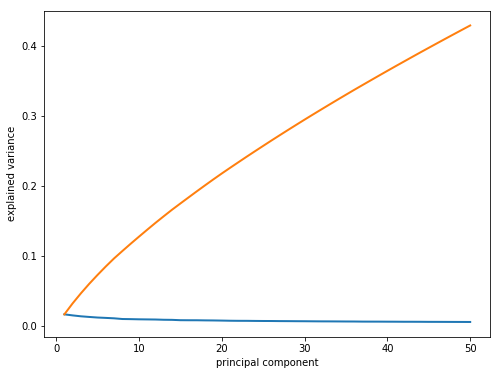

In [116]:
fig, ax = plt.subplots(figsize=(8,6))
x_values = range(1, dvv_pca.n_components_+1)
ax.plot(x_values, dvv_pca.explained_variance_ratio_, lw=2, label='explained variance')
ax.plot(x_values, np.cumsum(dvv_pca.explained_variance_ratio_), lw=2, label='cumulative explained variance')

ax.set_xlabel('principal component')
ax.set_ylabel('explained variance')
plt.show()

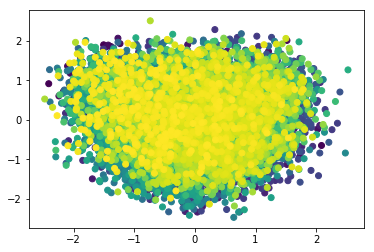

In [117]:
plt.scatter(dvv_pca.fit_transform(dvv)[:,0],dvv_pca.fit_transform(dvv)[:,1], c=np.arange(model.corpus_count), cmap='viridis')

plt.show()

In [118]:
import time

from sklearn.manifold import TSNE

In [119]:
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(dvv_pca.explained_variance_ratio_)))

Cumulative explained variation for 50 principal components: 0.42993437665137335


In [120]:
time_start = time.time()

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(dvv_pca.fit_transform(dvv))

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 14090 samples in 0.028s...
[t-SNE] Computed neighbors for 14090 samples in 21.474s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14090
[t-SNE] Computed conditional probabilities for sample 2000 / 14090
[t-SNE] Computed conditional probabilities for sample 3000 / 14090
[t-SNE] Computed conditional probabilities for sample 4000 / 14090
[t-SNE] Computed conditional probabilities for sample 5000 / 14090
[t-SNE] Computed conditional probabilities for sample 6000 / 14090
[t-SNE] Computed conditional probabilities for sample 7000 / 14090
[t-SNE] Computed conditional probabilities for sample 8000 / 14090
[t-SNE] Computed conditional probabilities for sample 9000 / 14090
[t-SNE] Computed conditional probabilities for sample 10000 / 14090
[t-SNE] Computed conditional probabilities for sample 11000 / 14090
[t-SNE] Computed conditional probabilities for sample 12000 / 14090
[t-SNE] Computed conditional probabilities for s

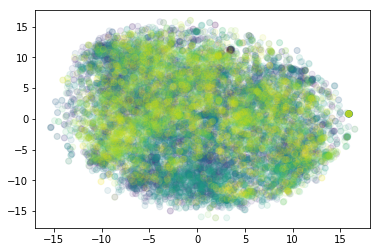

In [121]:
plt.scatter(tsne_pca_results[:,0], tsne_pca_results[:,1], alpha=0.1, c=np.arange(model.corpus_count), cmap='viridis')
plt.show()

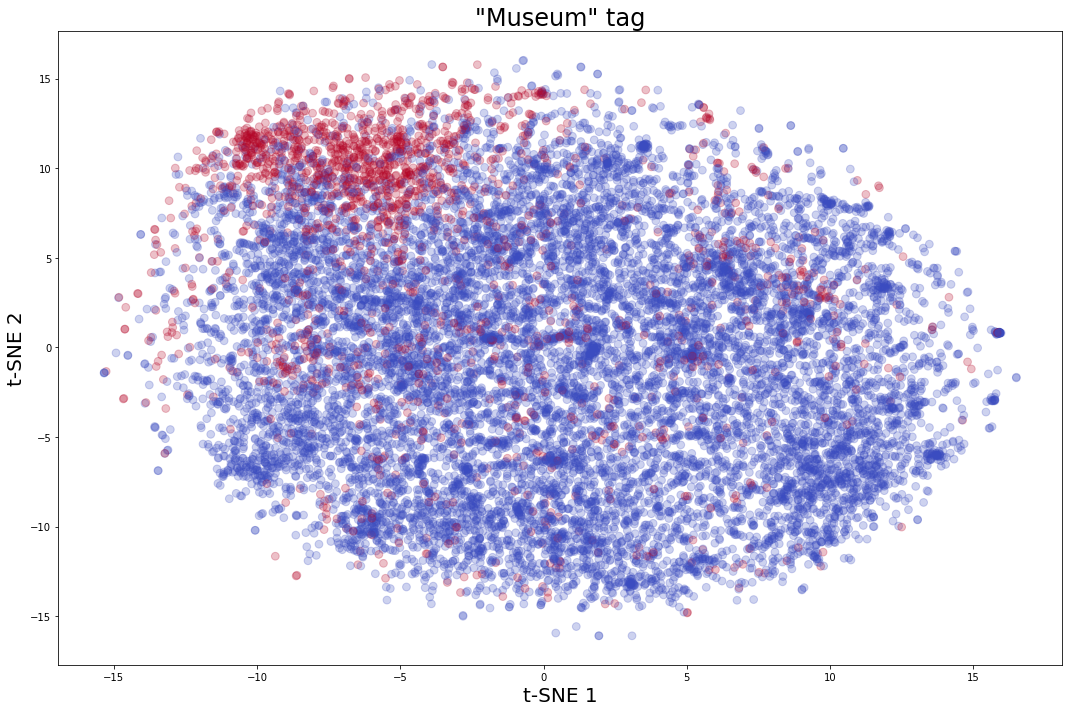

In [157]:
dockeys['haskey'] = [True if 'museum' in x else False for x in dockeys['keywords']]


plt.figure(figsize=(15, 10))
plt.scatter(tsne_pca_results[:,0], tsne_pca_results[:,1], alpha=0.25, s=60, c=dockeys['haskey'], cmap='coolwarm')
plt.xlabel('t-SNE 1', fontsize=20)
plt.ylabel('t-SNE 2', fontsize=20)
plt.title('"Museum" tag', fontsize=24)
plt.tight_layout()
plt.savefig('fig/tsne_museum.jpg', format='jpg', dpi=300)
plt.show()


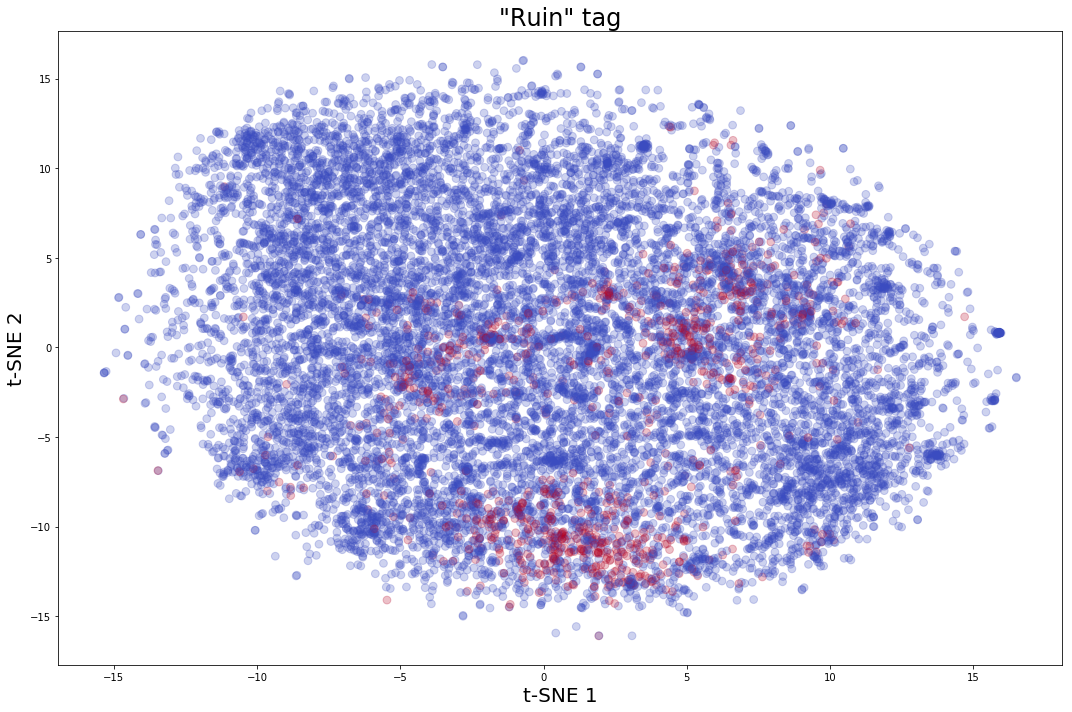

In [160]:
dockeys['haskey'] = [True if 'ruin' in x else False for x in dockeys['keywords']]


plt.figure(figsize=(15, 10))
plt.scatter(tsne_pca_results[:,0], tsne_pca_results[:,1], alpha=0.25, s=60, c=dockeys['haskey'], cmap='coolwarm')
plt.xlabel('t-SNE 1', fontsize=20)
plt.ylabel('t-SNE 2', fontsize=20)
plt.title('"Ruin" tag', fontsize=24)
plt.tight_layout()
plt.savefig('fig/tsne_ruin.jpg', format='jpg', dpi=300)
plt.show()


# Step 2: Duplicates

In [13]:
from scipy import stats

In [15]:
duplicates = list(aotable[aotable.duplicated('title', keep=False)]['title'].unique())

testdf = []
for i in duplicates:
    tmp = {'name': i,
          'id1': list(aotable[aotable['title'] == i]['id'].values)[0],
          'id2': list(aotable[aotable['title'] == i]['id'].values)[1]}
    testdf.append(tmp)

dups = pd.DataFrame(testdf)
dups.head(5)

,id1,id2,name
0,5875,16876,The Pinnacles
1,18896,17531,Cube House
2,2731,5738,Old Country Market
3,4513,698,Mountain View Cemetery
4,18344,3023,Old Burying Ground


In [16]:
# Find the similarities between all pairs of duplicates
pairsims = []
for index,row in dups.iterrows():
    pairsims.append(model.docvecs.similarity(str(row['id1']),str(row['id2'])))

dups['pairsim'] = pairsims

In [17]:
# for each row, get the distance to a random sample 
boot_t = []
boot_p = []

for si in range(1000):
    bootsample = []

    for i in range(len(dups)):
        randcol = random.choice(['id1','id2'])
        idofsample = str(dups[randcol].iloc[i])

        # randomly sample any other id
        tocompare = str(random.choice(aotable['id']))
        while tocompare == str(dups['id1'].iloc[i]) or tocompare == str(dups['id1'].iloc[i]):
            tocompare = str(random.choice(aotable['id']))

        # compare with random sample and add to vector
        bootsample.append(model.docvecs.similarity(idofsample, tocompare))

    tval, pval = stats.ttest_rel(dups['pairsim'],bootsample)

    boot_t.append(tval)
    boot_p.append(pval)

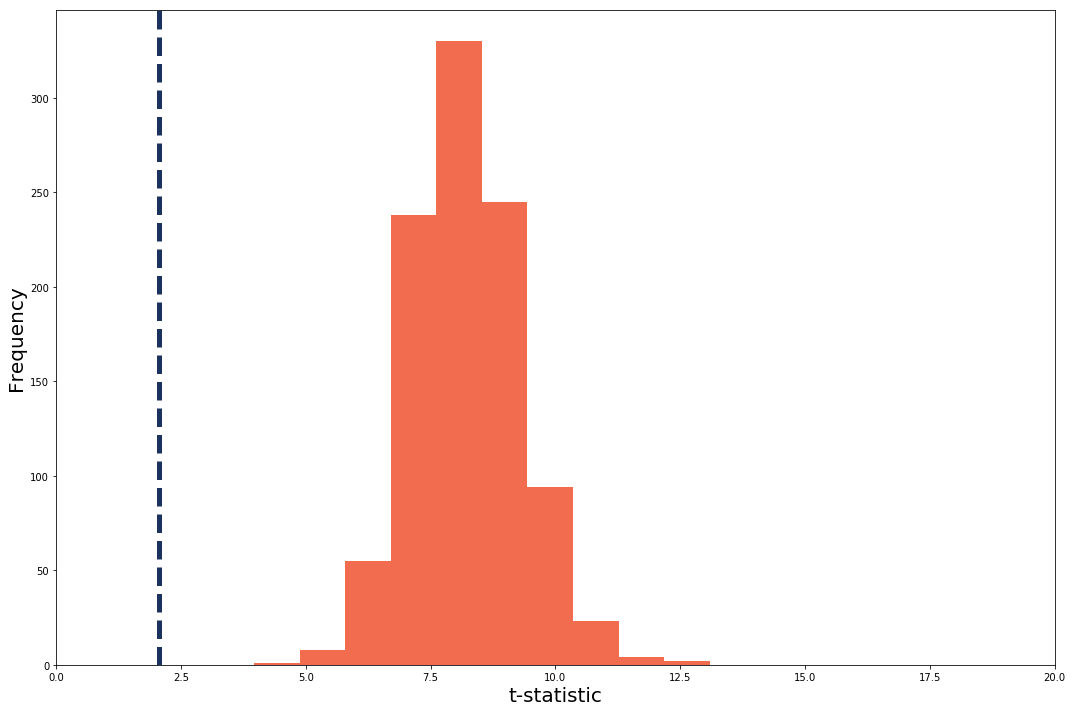

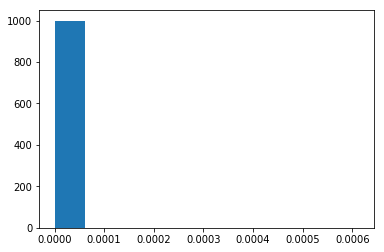

In [66]:
plt.figure(figsize=(15, 10))
plt.hist(boot_t, color='#f26c4fff')
plt.xlim(0,20)
plt.axvline(x=2.06, linestyle='--', linewidth=5, color='#1b325fff')
plt.xlabel('t-statistic', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.tight_layout()
plt.savefig('fig/VAL_duplicates.jpg', format='jpg', dpi=300)
plt.show()

plt.hist(boot_p, 10)
plt.show()

# Step 3: matching keywords

In [19]:
aotable.head(2)

,id,title,subtitle,city,country,location,url,physical_status,lat,lng,keywords,description,imgurl,subdesc,normsubdesc,tokens,weirdness,weirdpct
0,5561,Lake Hillier,An Australian lake whose pink hue defies scien...,,Australia,Australia,https://www.atlasobscura.com/places/lake-hillier,,-34.094179,123.203276,"wonders of salt,natural wonders,watery wonders","From a distance, Lake Hillier of Australia’s R...",https://assets.atlasobscura.com/media/W1siZiIs...,An Australian lake whose pink hue defies scien...,an australian lake whose pink hue defies scien...,"[an, australian, lake, whose, pink, hue, defie...",0.132377,26.78
1,4290,Gippsland Lakes Bioluminescence,Australian Lake set aglow by Noctiluca Scintil...,Raymond Island,Australia,"Raymond Island, Australia",https://www.atlasobscura.com/places/lake-gipps...,,-37.922431,147.791342,"watery wonders,bioluminescence","The conditions were rare, and they were perfec...",https://assets.atlasobscura.com/media/W1siZiIs...,Australian Lake set aglow by Noctiluca Scintil...,australian lake set aglow by noctiluca scintil...,"[australian, lake, set, aglow, by, noctiluca, ...",0.142318,4.00


In [20]:
aotable['splitkeys'] = [x.split(',') for x in aotable['keywords']]



In [21]:
# get a table of all keywords

megastring = ','.join(list(aotable['keywords']))

keys = megastring.split(",")

keystable = pd.DataFrame(Counter(keys), index=['count']).T.reset_index().rename(columns={'index':'keyword'})

keystable = keystable.sort_values(by='count', ascending=True).reset_index(drop=True).drop(0)

len(keystable)

2277

In [22]:
# Get only keywords with more than 3 matches
keystable = keystable[keystable['count'] > 2].reset_index(drop=True)
keystable = keystable[keystable['keyword'] != ''].reset_index(drop=True)
len(keystable)

1390

In [23]:
keystable.head(2)

,keyword,count
0,cold war (internal),3
1,mythology (internal),3


In [24]:
key_t = []
key_p = []

for j in range(1000):
    simgroup = []
    outgroup = []
    
    for i in range(30):
        # get a random keyword
        randkey = random.choice(keystable['keyword'])

        # subset table to include only locations that have the keyword
        tablematch = aotable[[randkey in x for x in aotable['keywords']]]
        tablenotmatch = aotable[[randkey not in x for x in aotable['keywords']]]

        # choose 2 from the matching table
        twomatching = [str(x) for x in random.sample(list(tablematch['id']),2)]

        # choose 1 from the non-matching table
        onenotmatching = str(random.choice(list(tablenotmatch['id'])))

        simgroup.append(model.docvecs.similarity(twomatching[0], twomatching[1])) 
        outgroup.append(model.docvecs.similarity(twomatching[0], onenotmatching))

    tval, pval = stats.ttest_rel(simgroup, outgroup)

    key_t.append(tval)
    key_p.append(pval)

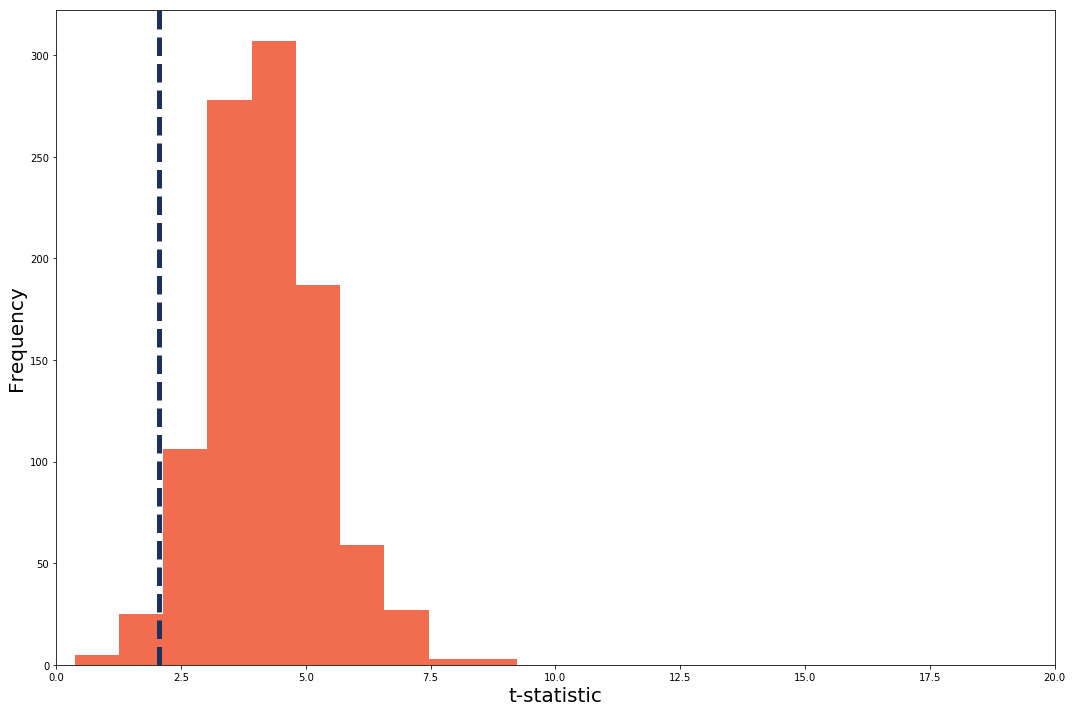

In [32]:
plt.figure(figsize=(15, 10))
plt.hist(key_t, color='#f26c4fff')
plt.xlim(0,20)
plt.axvline(x=2.06, linestyle='--', linewidth=5, color='#1b325fff')
plt.xlabel('t-statistic', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.tight_layout()
plt.savefig('fig/VAL_keyword.jpg', format='jpg', dpi=300)
plt.show()

In [31]:
np.mean([x < 0.05 for x in key_p])

0.976

# Step 4: Testing analogies

In [14]:
acctest = model.wv.accuracy('data/questions-words.txt')

In [38]:
for i in range(len(acctest)):
    print(acctest[i]['section'], ':', round(100*(len(acctest[i]['correct'])/(len(acctest[i]['correct'])+len(acctest[i]['incorrect']))),2)) 

capital-common-countries : 44.29
capital-world : 22.93
currency : 0.0
city-in-state : 13.83
family : 21.93
gram1-adjective-to-adverb : 1.26
gram2-opposite : 0.37
gram3-comparative : 5.88
gram4-superlative : 6.77
gram5-present-participle : 13.68
gram6-nationality-adjective : 58.79
gram7-past-tense : 10.14
gram8-plural : 42.35
gram9-plural-verbs : 4.55
total : 20.88


In [51]:
accsec = [acctest[i]['section'] for i in range(len(acctest))]
accscore = [round(100*(len(acctest[i]['correct'])/(len(acctest[i]['correct'])+len(acctest[i]['incorrect']))),2) for i in range(len(acctest))]

In [62]:
modelac = pd.DataFrame([accsec,accscore]).T.reset_index().rename(columns={0:'anset', 1:'accuracy'})[['anset','accuracy']]
modelac = modelac.sort_values(by='accuracy', ascending=False).reset_index(drop=True)

In [74]:
modelac = modelac.append(modelac.iloc[5])
modelac.reset_index(drop=True).drop(5).reset_index(drop=True)

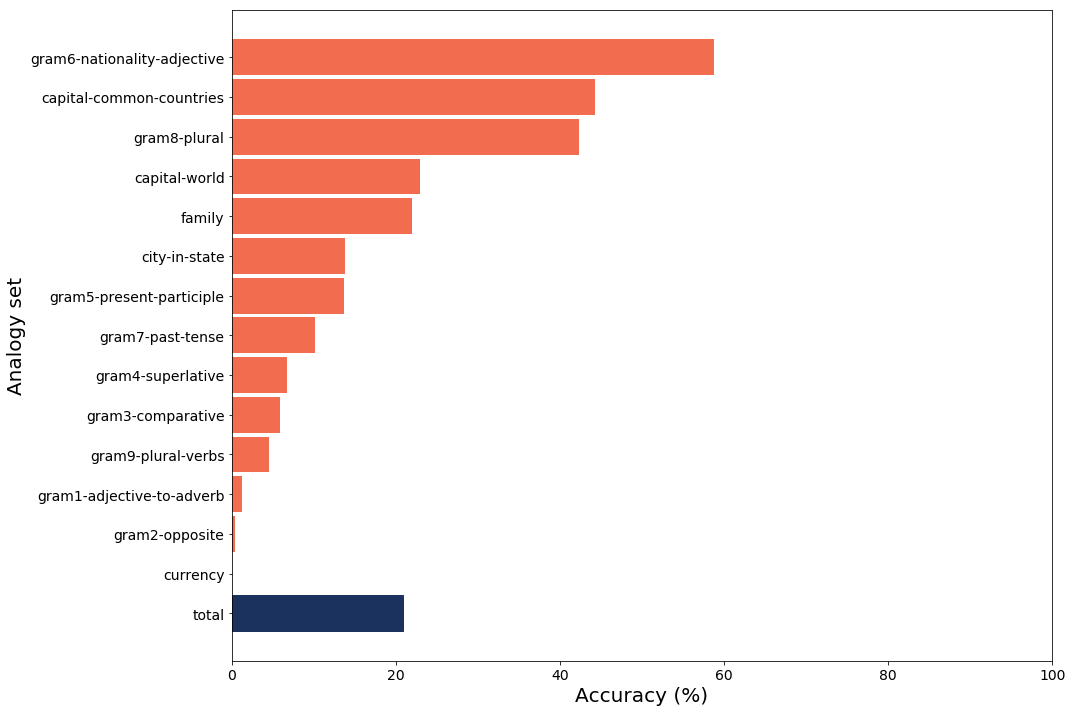

In [102]:
plt.figure(figsize=(15,10))
barlist = plt.barh(range(15), modelac['accuracy'], height=0.9, color='#f26c4fff')
barlist[14].set_color('#1b325fff')
plt.xlabel('Accuracy (%)', fontsize=20)
plt.xticks(fontsize=14)
plt.xlim(0,100)
plt.ylabel('Analogy set', fontsize=20)
plt.yticks(range(15), modelac['anset'], fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('fig/VAL_analogies.jpg', format='jpg', dpi=300)
plt.show()